In [0]:
import os 
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as  tf
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation

import datetime

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('/content/drive/My Drive/gold/data')

In [0]:
tf.set_random_seed(777) 
# 랜덤에 의해 똑같은 결과를 재현하도록 시드 설정

In [0]:
# min_max_scaling

def min_max_scaling(x):
  x_np = np.asarray(x)
  return (x_np - x_np.min()) / (x_np.max() - x_np.min() + 1e-7) # 1e-7은 0으로 나누는 오류예방차원

In [0]:
seq_length = 20            # 시퀀스의 길이(시계열데이터 입력 개수)

In [0]:
import pickle
gold = pickle.load(open('gold_price.pkl', 'rb'))

In [0]:
gold.columns

Index(['USD/T.oz', 'index_price', 'index_volume', 'index_change', 'cny/krw',
       'usd/krw', '100jpy/krw', 'eur/krw', 'gbp/krw', 'nasdaq_volume',
       'kospi_volume', 'dow_volume', 'snp500_volume', 'WTI_barrel', 'nasdaq',
       'kospi', 'dow', 'snp500'],
      dtype='object')

In [0]:
gold.info()  # USD/T.oz (금가격)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2298 entries, 2010-01-04 to 2019-07-31
Data columns (total 18 columns):
USD/T.oz         2298 non-null float64
index_price      2298 non-null float64
index_volume     2298 non-null float64
index_change     2298 non-null float64
cny/krw          2298 non-null float64
usd/krw          2298 non-null float64
100jpy/krw       2298 non-null float64
eur/krw          2298 non-null float64
gbp/krw          2298 non-null float64
nasdaq_volume    2298 non-null float64
kospi_volume     2298 non-null float64
dow_volume       2298 non-null float64
snp500_volume    2298 non-null float64
WTI_barrel       2298 non-null float64
nasdaq           2298 non-null float64
kospi            2298 non-null float64
dow              2298 non-null float64
snp500           2298 non-null float64
dtypes: float64(18)
memory usage: 341.1 KB


In [0]:
gold_info = gold.values[0:,:].astype(np.float)

In [0]:
print('gold_info.shape : ', gold_info.shape)
print('gold_info[0] : ', gold_info[0])

gold_info.shape :  (2298, 18)
gold_info[0] :  [ 1.10980000e+03  7.78300000e+01  1.83900000e+01 -5.90000000e-01
  1.68830000e+02  1.15250000e+03  1.24085000e+03  1.65050000e+03
  1.86106000e+03  1.93138000e+09  2.95600000e+05  1.79780000e+08
  3.99140000e+09  8.15200000e+01  2.30336191e+03  1.69036799e+03
  1.05268541e+04  1.12659402e+03]


In [0]:
# 금 가격 정규화

price = gold_info[:,:1]
norm_price = min_max_scaling(price)

In [0]:
# 나머지 정규화
volume  = gold_info[:,1:]
norm_volume = min_max_scaling(volume)

In [0]:
# 정규화된 금가격과 나머지들을 합침

x = np.concatenate((norm_price, norm_volume), axis=1)

In [0]:
dataX = []   # 입력으로 사용될 Sequence Data
dataY = []   # 출력으로 사용

for i in range(0, len(y) - seq_length):
  _x = x[i : i+seq_length]
  _y = y[i + seq_length]  # 다음날 금값
  
  if i is 0:
    print(_x, '->', _y)  # 첫번쨰 행만 출력
  dataX.append(_x)
  dataY.append(_y)

[[7.03825499e-02 7.55523031e-09 1.95708908e-09 1.69526484e-10
  1.61257359e-08 1.08769134e-07 1.17090059e-07 1.55671461e-07
  1.75502293e-07 1.81900034e-01 2.78402411e-05 1.69319287e-02
  3.75915561e-01 7.90275961e-09 2.17158898e-07 1.59426284e-07
  9.91658741e-07 1.06329273e-07]
 [8.89540798e-02 7.55711394e-09 2.04279414e-09 2.27918940e-10
  1.59788130e-08 1.07780230e-07 1.17120197e-07 1.55340885e-07
  1.72807764e-07 2.23008323e-01 3.83885556e-05 1.77569576e-02
  2.34607702e-01 7.92347951e-09 2.17483455e-07 1.59800372e-07
  9.95452503e-07 1.07064265e-07]
 [8.87766448e-02 7.53874857e-09 1.73293739e-09 2.01548153e-10
  1.59015842e-08 1.07262232e-07 1.16380873e-07 1.53608889e-07
  1.71773652e-07 2.12222671e-01 4.00649842e-05 1.75215042e-02
  4.68331982e-01 8.05344982e-09 2.17212215e-07 1.60550243e-07
  9.95790453e-07 1.07274097e-07]
 [9.74709598e-02 7.58113019e-09 1.68584670e-09 2.79718699e-10
  1.58733298e-08 1.07073869e-07 1.15389143e-07 1.53649387e-07
  1.70553061e-07 2.13796442e-01 4

In [0]:
# train/test 데이터생성

train_size = int(len(dataY) * 0.7) # 70% 학습용 데이터
test_size = len(dataY) - train_size # 30% 테스트용 데이터


In [0]:
#학습용 데이터 생성

x_train = np.array(dataX[0:train_size])
y_train = np.array(dataY[0:train_size])

In [0]:
# 테스트용 데이터 생성

x_test = np.array(dataX[train_size:len(dataX)])
y_test = np.array(dataY[train_size:len(dataY)])

# linear , rmsprop 
> linear
* 비선형 함수는 linear를 주로 사용한다.

> rmsprop 
* 과거의 모든 기울기를 균일하게 더하지 않고 새로운 기울기의 정보만 반영하도록 해서 학습률이 크게 떨어져 0에 가까워지는 것을 방지하는 방법이다.

In [0]:
# lstm model

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(20,18)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1, activation='linear'))      # 비선형함수인 linear를 주로 사용한다.
model.compile(loss='mse', optimizer='rmsprop')  # rmsprop : 과거의 모든 기울기를 균일하게 더하지 않고 새로운 기울기의 정보만 반영하도록 해서 학습률이 크게 떨어져 0에 가까워지는 것을 방지하는 방법이다.
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 20, 50)            13800     
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 34,051
Trainable params: 34,051
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=10, epochs=30)

Train on 1594 samples, validate on 684 samples
Epoch 1/30
1594/1594 [==============================] - 16s 10ms/step - loss: 0.0014 - val_loss: 2.4292e-04
Epoch 2/30
1594/1594 [==============================] - 15s 10ms/step - loss: 0.0012 - val_loss: 2.3880e-04
Epoch 3/30
1594/1594 [==============================] - 16s 10ms/step - loss: 0.0011 - val_loss: 3.5805e-04
Epoch 4/30
1594/1594 [==============================] - 16s 10ms/step - loss: 9.6218e-04 - val_loss: 2.5065e-04
Epoch 5/30
1594/1594 [==============================] - 16s 10ms/step - loss: 8.6791e-04 - val_loss: 4.6499e-04
Epoch 6/30
1594/1594 [==============================] - 16s 10ms/step - loss: 8.0835e-04 - val_loss: 7.2734e-04
Epoch 7/30
1594/1594 [==============================] - 16s 10ms/step - loss: 7.2364e-04 - val_loss: 9.4037e-04
Epoch 8/30
1594/1594 [==============================] - 16s 10ms/step - loss: 7.2179e-04 - val_loss: 1.3591e-04
Epoch 9/30
1594/1594 [==============================] - 16s 10ms/step

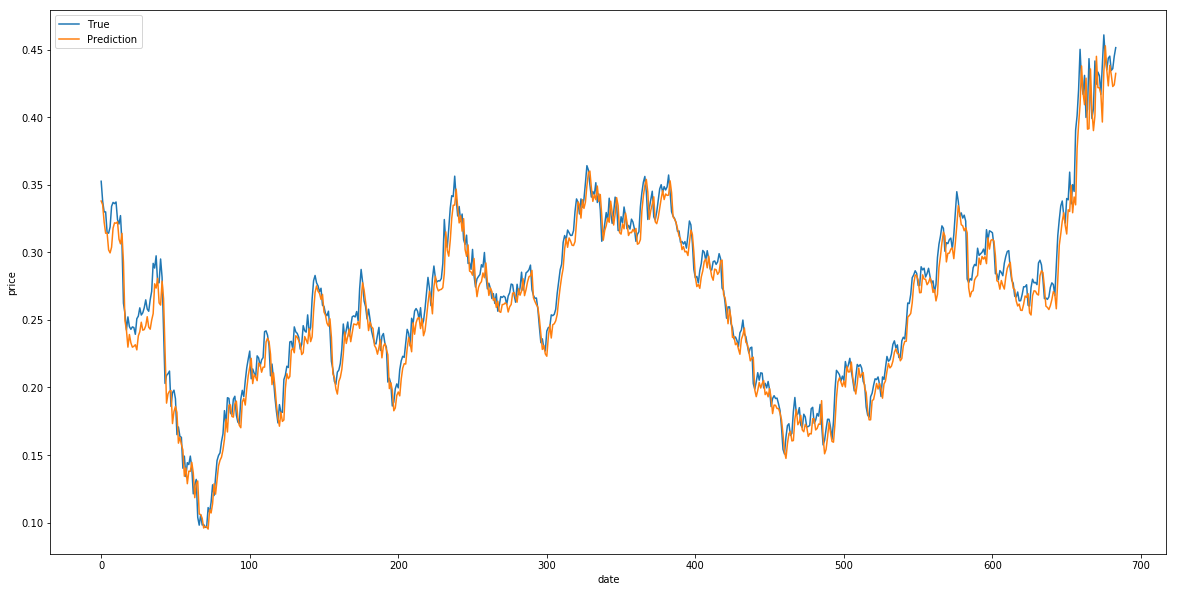

In [0]:
pred = model.predict(x_test)


fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)

ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.xlabel('date')
plt.ylabel('price')
plt.show()

In [0]:
linear_rms = pred.mean() - y_test.mean()

-0.006320903637367592

# softsign, adam
> softsign 
* 부호sign 함수를 연속 함수로 근사한 것

> adam
* 학습률을 줄여나가고 속도를 계산하여 학습의 갱신강도를 적응적으로 조정해 나아감

In [0]:
########################### sofrsign, adam

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(20,18)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1, activation='softsign'))       # softsign = 부호sign 함수를 연속 함수로 근사한 것
model.compile(loss='mse', optimizer='adam')      # adam = 학습률을 줄여나가고 속도를 계산하여 학습의 갱신강도를 적응적으로 조정해 나아감
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 20, 50)            13800     
_________________________________________________________________
lstm_26 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 51        
Total params: 34,051
Trainable params: 34,051
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=10, epochs=30)

Train on 1594 samples, validate on 684 samples
Epoch 1/30
1594/1594 [==============================] - 20s 12ms/step - loss: 0.0130 - val_loss: 8.8616e-04
Epoch 2/30
1594/1594 [==============================] - 16s 10ms/step - loss: 0.0024 - val_loss: 6.0316e-04
Epoch 3/30
1594/1594 [==============================] - 16s 10ms/step - loss: 0.0019 - val_loss: 5.8672e-04
Epoch 4/30
1594/1594 [==============================] - 16s 10ms/step - loss: 0.0018 - val_loss: 4.2865e-04
Epoch 5/30
1594/1594 [==============================] - 16s 10ms/step - loss: 0.0016 - val_loss: 4.1615e-04
Epoch 6/30
1594/1594 [==============================] - 16s 10ms/step - loss: 0.0015 - val_loss: 5.1533e-04
Epoch 7/30
1594/1594 [==============================] - 16s 10ms/step - loss: 0.0013 - val_loss: 4.9143e-04
Epoch 8/30
1594/1594 [==============================] - 16s 10ms/step - loss: 0.0012 - val_loss: 2.9855e-04
Epoch 9/30
1594/1594 [==============================] - 16s 10ms/step - loss: 0.0012 - va

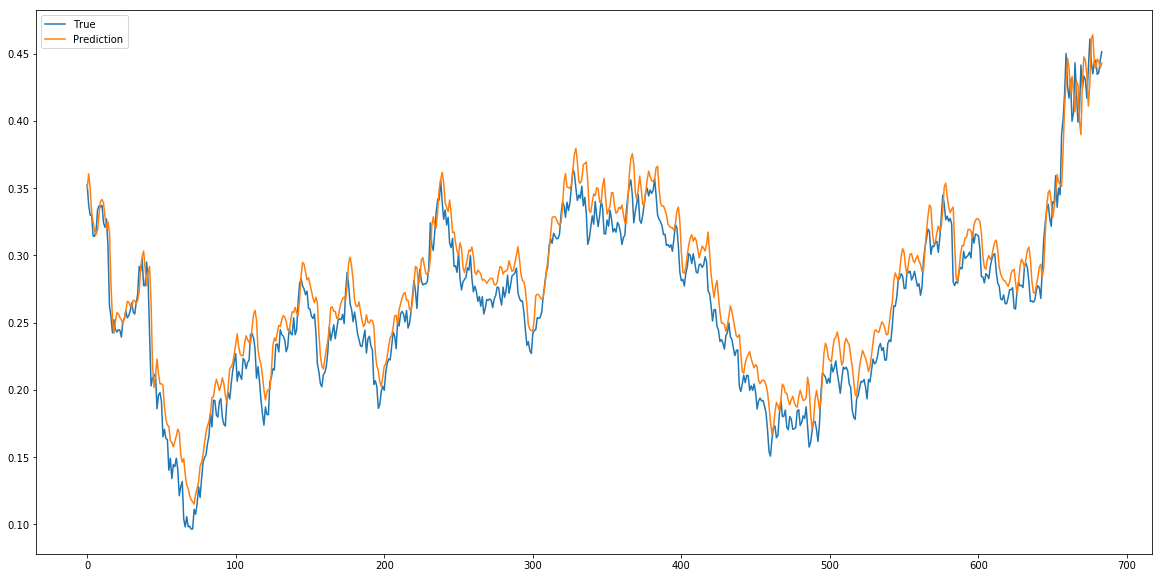

In [0]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

In [0]:
softsign_adam = pred.mean() - y_test.mean()
softsign_adam

0.01353101935152401

In [0]:
pred[-1].mean() - y_test[-1].mean()

-0.005008755902583317

In [0]:
# lstm model

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(20,18)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')       # adam = 학습률을 줄여나가고 속도를 계산하여 학습의 갱신강도를 적응적으로 조정해 나아감
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 20, 50)            13800     
_________________________________________________________________
lstm_18 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
Total params: 34,051
Trainable params: 34,051
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=10, epochs=30)

Train on 1594 samples, validate on 684 samples
Epoch 1/30
1594/1594 [==============================] - 18s 11ms/step - loss: 0.0093 - val_loss: 7.3494e-04
Epoch 2/30
1594/1594 [==============================] - 16s 10ms/step - loss: 0.0017 - val_loss: 5.3481e-04
Epoch 3/30
1594/1594 [==============================] - 16s 10ms/step - loss: 0.0014 - val_loss: 4.3719e-04
Epoch 4/30
1594/1594 [==============================] - 16s 10ms/step - loss: 0.0014 - val_loss: 7.2453e-04
Epoch 5/30
1594/1594 [==============================] - 16s 10ms/step - loss: 0.0012 - val_loss: 3.4728e-04
Epoch 6/30
1594/1594 [==============================] - 16s 10ms/step - loss: 9.4131e-04 - val_loss: 4.6160e-04
Epoch 7/30
1594/1594 [==============================] - 16s 10ms/step - loss: 9.1899e-04 - val_loss: 3.0864e-04
Epoch 8/30
1594/1594 [==============================] - 15s 10ms/step - loss: 7.9782e-04 - val_loss: 3.3989e-04
Epoch 9/30
1594/1594 [==============================] - 15s 10ms/step - loss:

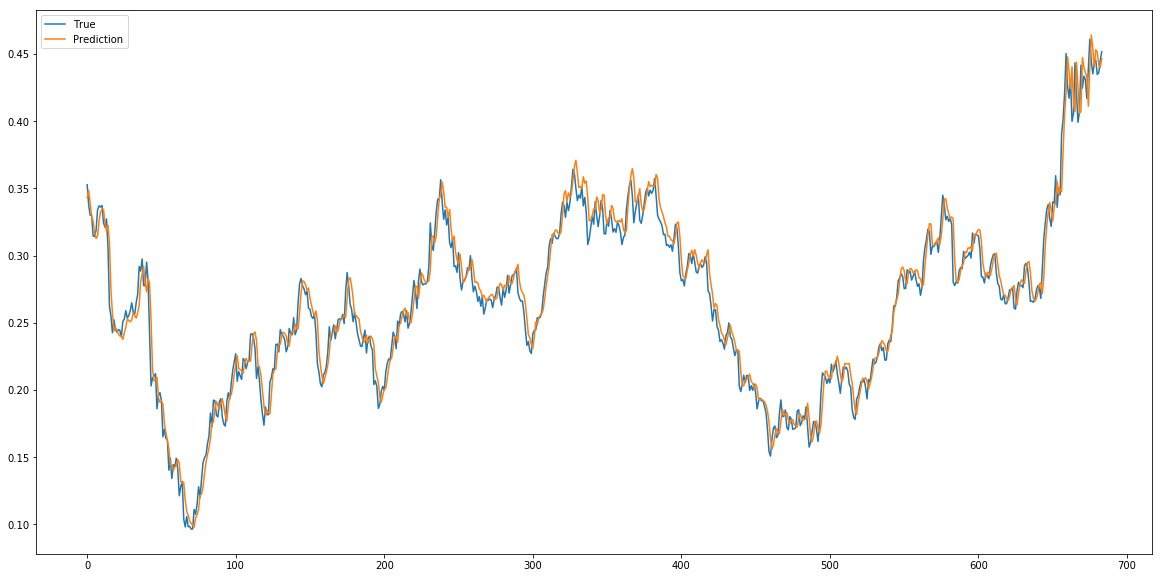

In [0]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

In [0]:
linear_adam = pred.mean() - y_test.mean()

0.0024332007384716414

In [0]:
# lstm model

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(20,18)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1, activation='softsign'))
model.compile(loss='mse', optimizer='rmsprop')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 20, 50)            13800     
_________________________________________________________________
lstm_20 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 51        
Total params: 34,051
Trainable params: 34,051
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=10, epochs=30)

Train on 1594 samples, validate on 684 samples
Epoch 1/30
1594/1594 [==============================] - 19s 12ms/step - loss: 0.0074 - val_loss: 0.0015
Epoch 2/30
1594/1594 [==============================] - 16s 10ms/step - loss: 0.0029 - val_loss: 6.4639e-04
Epoch 3/30
1594/1594 [==============================] - 16s 10ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 4/30
1594/1594 [==============================] - 15s 10ms/step - loss: 0.0019 - val_loss: 3.7394e-04
Epoch 5/30
1594/1594 [==============================] - 16s 10ms/step - loss: 0.0016 - val_loss: 2.5511e-04
Epoch 6/30
1594/1594 [==============================] - 16s 10ms/step - loss: 0.0013 - val_loss: 5.6351e-04
Epoch 7/30
1594/1594 [==============================] - 16s 10ms/step - loss: 0.0013 - val_loss: 2.7717e-04
Epoch 8/30
1594/1594 [==============================] - 16s 10ms/step - loss: 0.0011 - val_loss: 2.2195e-04
Epoch 9/30
1594/1594 [==============================] - 16s 10ms/step - loss: 0.0010 - val_loss: 

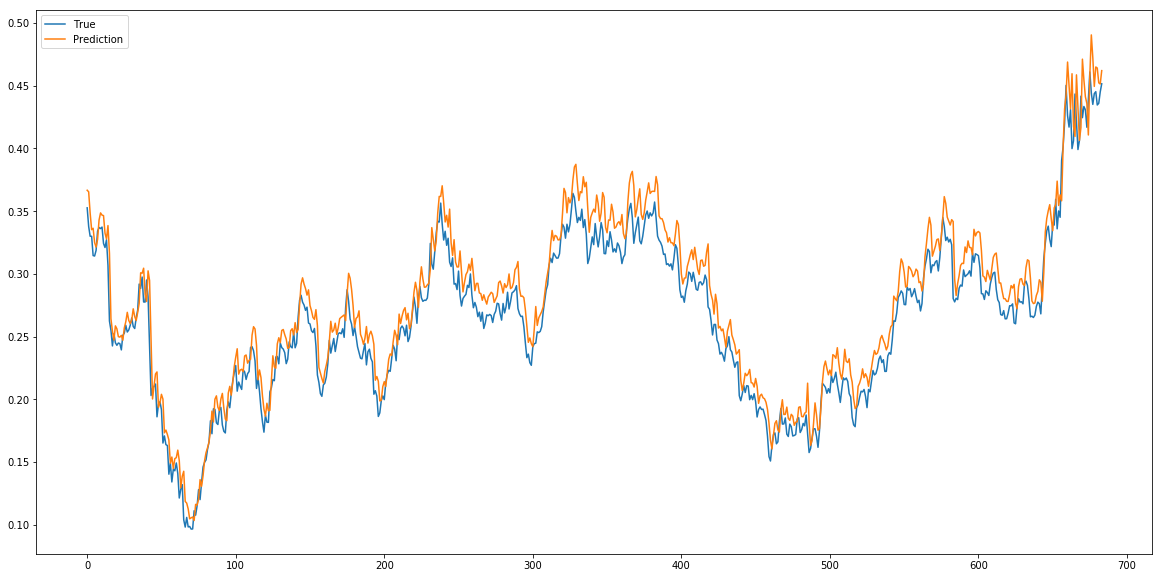

In [0]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

In [0]:
softsign_rms = pred.mean() - y_test.mean()

0.014289369247001305

 # ReLu
 > 입력값이 0보다 작으면 0이고 0보다 크면 입력값 그대로를 내보낸다.

In [0]:
# lstm model

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(20,18)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1, activation='relu'))        # ReLu는 입력값이 0보다 작으면 0이고 0보다 크면 입력값 그대로를 내보낸다.
model.compile(loss='mse', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 20, 50)            13800     
_________________________________________________________________
lstm_22 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 51        
Total params: 34,051
Trainable params: 34,051
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=10, epochs=30)

Train on 1594 samples, validate on 684 samples
Epoch 1/30
1594/1594 [==============================] - 18s 11ms/step - loss: 0.0059 - val_loss: 6.1181e-04
Epoch 2/30
1594/1594 [==============================] - 15s 10ms/step - loss: 0.0017 - val_loss: 6.4519e-04
Epoch 3/30
1594/1594 [==============================] - 15s 10ms/step - loss: 0.0015 - val_loss: 4.7155e-04
Epoch 4/30
1594/1594 [==============================] - 16s 10ms/step - loss: 0.0012 - val_loss: 3.4688e-04
Epoch 5/30
1594/1594 [==============================] - 15s 10ms/step - loss: 0.0012 - val_loss: 3.2107e-04
Epoch 6/30
1594/1594 [==============================] - 15s 10ms/step - loss: 9.1027e-04 - val_loss: 3.0821e-04
Epoch 7/30
1594/1594 [==============================] - 15s 10ms/step - loss: 8.2859e-04 - val_loss: 5.2913e-04
Epoch 8/30
1594/1594 [==============================] - 15s 10ms/step - loss: 8.6669e-04 - val_loss: 2.6748e-04
Epoch 9/30
1594/1594 [==============================] - 15s 10ms/step - loss:

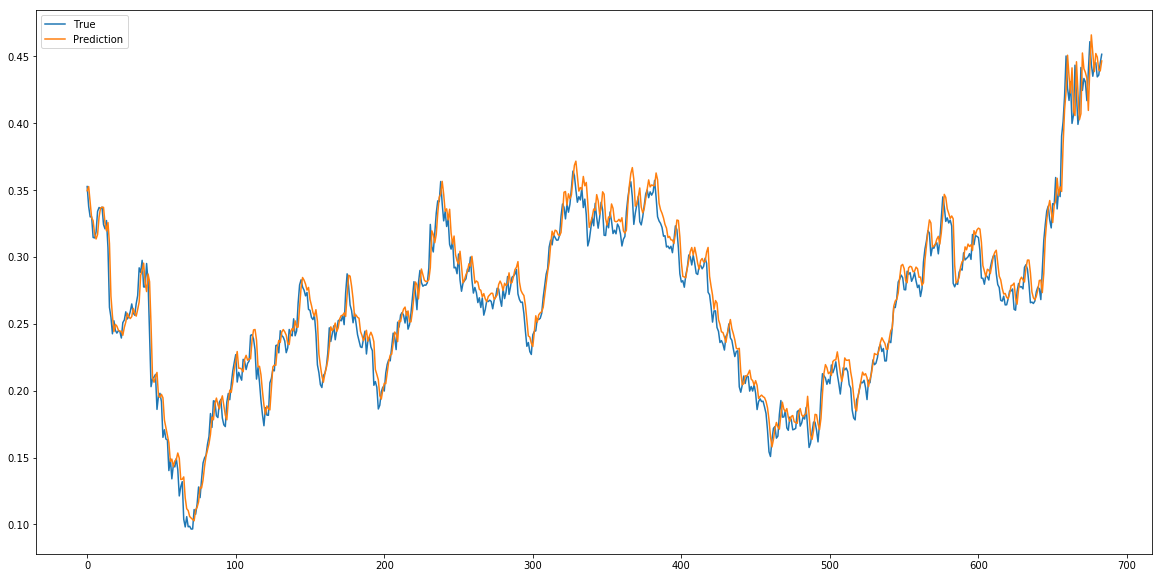

In [0]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

In [0]:
relu_adam = pred.mean() - y_test.mean()

0.004722913167518272